In [1]:
model_path = None
data_dir = None
export_dir = None

In [184]:
import os
import os.path as osp
import glob
run_name = '201805'
train_model_path = 'results/cell_counting_training/' + run_name + '/cell_counting_model.h5'
app_model_dir = 'models/cell_counting_application/' + run_name
image_path_patterns = '/lab/data/celldom/data/dataset02/*.jpg'
train_data_files_meta_path = 'results/cell_counting_training/201805/data_files.csv'
result_dir = 'results/cell_counting_application/' + run_name
config_script = 'config02.py'

In [185]:
%run $config_script
%matplotlib inline
import os
import os.path as osp
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from mrcnn import visualize as mrcnn_viz
from mrcnn import model as mrcnn_model_lib
from cvutils.mrcnn import model as mrcnn_model
from cvutils.rectlabel import io as rectlabel_io
from cvutils.mrcnn.session import init_keras_session
from celldom.dataset import CelldomDataset
from celldom import seed
image_path_patterns = image_path_patterns.split(',')
os.makedirs(app_model_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

In [75]:
train_data_files = None
if train_data_files_meta_path is not None:
    train_data_files = pd.read_csv(train_data_files_meta_path)
    train_data_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 15 columns):
annot_exists             824 non-null bool
annot_path               824 non-null object
ct:aptnum                160 non-null float64
ct:cell                  160 non-null float64
ct:cellclump             160 non-null float64
ct:chamber               160 non-null float64
ct:channel               160 non-null float64
ct:marker                160 non-null float64
ct:stnum                 160 non-null float64
ct:trap                  160 non-null float64
image_name               824 non-null object
image_path               824 non-null object
pct:cell_to_cellclump    144 non-null float64
exclusion                722 non-null object
group                    824 non-null object
dtypes: bool(1), float64(9), object(5)
memory usage: 91.0+ KB


In [11]:
image_paths = [f for p in image_path_patterns for f in glob.glob(p)]
print('Number of images detected: {}'.format(len(image_paths)))
image_paths[:5]

Number of images detected: 824


['/lab/data/celldom/data/dataset02/BF_ST_003_APT_010Day0.jpg',
 '/lab/data/celldom/data/dataset02/BF_ST_007_APT_009Day3.jpg',
 '/lab/data/celldom/data/dataset02/BF_ST_000_APT_000Day0.jpg',
 '/lab/data/celldom/data/dataset02/BF_ST_000_APT_000Day1.jpg',
 '/lab/data/celldom/data/dataset02/BF_ST_000_APT_000Day2.jpg']

In [12]:
dataset = CelldomDataset()
dataset.initialize(image_paths, CLASS_NAMES)
dataset.prepare()

In [13]:
model_config = CelldomInferenceConfig()
model_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        250
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               250
MEAN_PIXEL                     [123.7 116.8 103.9]
MIN

In [14]:
model = mrcnn_model.get_model(
    mode="inference", config=model_config, 
    model_dir=app_model_dir,
    init_with='file', file=train_model_path
)

In [126]:
# image_id = 5
# image = dataset.load_image(image_id)
# r = model.detect([image], verbose=1)[0]

# # mrcnn_viz.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
# #                             dataset.class_names, r['scores'], show_bbox=False)
# mrcnn_viz.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset.class_names, None, show_bbox=True)

In [54]:
r['rois'].shape, r['masks'].shape, r['class_ids'].shape

((75, 4), (300, 324, 75), (75,))

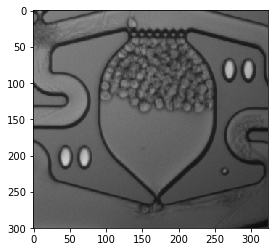

In [55]:
plt.imshow(image)

In [56]:
r['rois'][2], dataset.class_names[r['class_ids'][2]]
# y1, x1, y2, x2 = box

(array([ 30,  92, 264, 255], dtype=int32), 'Chamber')

In [65]:
def generate_detections(model, dataset):
    df = []
    for image_id in dataset.image_ids:
        image = dataset.load_image(image_id)
        detection = model.detect([image], verbose=0)[0]
        image_path = dataset.image_reference(image_id)
        df.append({
            'image_id': image_id, 
            'image': image, 
            'detection': detection,
            'image_path': image_path,
            'image_name': osp.basename(image_path)
        })
    return pd.DataFrame(df)
        

df_detection = generate_detections(model, dataset)
df_detection.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 5 columns):
detection     824 non-null object
image         824 non-null object
image_id      824 non-null int64
image_name    824 non-null object
image_path    824 non-null object
dtypes: int64(1), object(4)
memory usage: 32.3+ KB


In [76]:
# If training data file metadata was given, correlate the images for which
# predictions are being made to the data partition groups assigned in training
if train_data_files is not None:
    df_detection['image_group'] = df_detection['image_name'].map(
        train_data_files.set_index('image_name')['group'].to_dict()
    ).fillna('external')
# Otherwise, classify all images as "external"
else:
    df_detection['image_group'] = 'external'
    
# There should never end up being more than 3 groups at TOW
assert df_detection['image_group'].nunique() <= 3
assert df_detection['image_group'].notnull().all()
df_detection['image_group'].value_counts()

external      722
training       82
validation     20
Name: image_group, dtype: int64

In [169]:
def summarize_chip_detections(
    dataset, detection, metadata=None,
    cell_class='Cell', chamber_class='Chamber', cellclump_class='CellClump'
    ):
    
    rois, masks = detection['rois'], detection['masks']
    scores, class_ids = detection['scores'], detection['class_ids']
    
    meta = {} if metadata is None else metadata
    res = {}
    
    # Add number of cells detected in image
    cell_class_id = dataset.class_names.index(cell_class)
    cell_masks = masks[..., class_ids == cell_class_id]
    assert cell_masks.ndim == 3
    cellunion_mask = cell_masks.max(axis=-1) if cell_masks.shape[-1] > 0 else None
    res['chip_cell_count'] = cell_masks.shape[-1]
    
    # Add number of each class instances detected in image
    assert cell_class not in EXPECTED_CLASS_COUNTS
    for class_name in sorted(list(EXPECTED_CLASS_COUNTS.keys())):
        class_id = dataset.class_names.index(class_name)
        class_count = (class_ids == class_id).sum()
        res['chip_{}_count'.format(class_name.lower())] = class_count
        
    # Fetch chamber mask union or none if no chamber masks exist
    chamber_class_id = dataset.class_names.index(chamber_class)
    chamber_mask = masks[..., class_ids == chamber_class_id]
    assert chamber_mask.ndim == 3
    chamber_mask = chamber_mask.max(axis=-1) if chamber_mask.shape[-1] > 0 else None
    res['chip_chamber_area'] = chamber_mask.sum() if chamber_mask is not None else np.nan
    
    # Fetch cell clump mask union of none if no cellclumps exist
    cellclump_class_id = dataset.class_names.index(cellclump_class)
    cellclump_mask = masks[..., class_ids == cellclump_class_id]
    assert cellclump_mask.ndim == 3
    cellclump_mask = cellclump_mask.max(axis=-1) if cellclump_mask.shape[-1] > 0 else None
    
    def add_chamber_occupance(key, mask):
        if chamber_mask is None:
            res[key] = np.nan
        elif mask is None:
            res[key] = 0.0
        else:
            res[key] = 100. * np.logical_and(mask, chamber_mask).sum() / chamber_mask.sum()
        
    # Determine fraction of chamber occupied as intersection of cellclumps/cellunions 
    # and chamber divided by chamber area
    add_chamber_occupance('chip_cellclump_chamber_pct', cellclump_mask)
    add_chamber_occupance('chip_cellunion_chamber_pct', cellunion_mask)

    return {**meta, **res}
    

df_chip = pd.DataFrame([
    summarize_chip_detections(dataset, r['detection'], metadata=r.to_dict())
    for i, r in df_detection.iterrows()
])
df_chip.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 16 columns):
chip_aptnum_count             824 non-null int64
chip_cell_count               824 non-null int64
chip_cellclump_chamber_pct    787 non-null float64
chip_cellunion_chamber_pct    787 non-null float64
chip_chamber_area             787 non-null float64
chip_chamber_count            824 non-null int64
chip_channel_count            824 non-null int64
chip_marker_count             824 non-null int64
chip_stnum_count              824 non-null int64
chip_trap_count               824 non-null int64
detection                     824 non-null object
image                         824 non-null object
image_group                   824 non-null object
image_id                      824 non-null int64
image_name                    824 non-null object
image_path                    824 non-null object
dtypes: float64(3), int64(8), object(5)
memory usage: 229.7 MB


In [240]:
# Parse image metadata (stnum, aptnum, etc) (eg BF_ST_000_APT_008Day3)
def get_st_num(image_name):
    return int(image_name.split('_')[2])

def get_apt_num(image_name):
    return int(image_name.split('_')[4].split('Day')[0])

def get_day(image_name):
    return int(image_name.split('_')[4].split('Day')[1].split('.')[0])

df_chip['image_meta_stnum'] = df_chip['image_name'].apply(get_st_num)
df_chip['image_meta_aptnum'] = df_chip['image_name'].apply(get_apt_num)
df_chip['image_meta_day'] = df_chip['image_name'].apply(get_day)

In [246]:
from skimage.measure import regionprops, points_in_poly


def get_bbox(rois):
    if len(rois) != 1:
        return None
    
    # See https://github.com/matterport/Mask_RCNN/blob/4129a27275c48c672f6fd8c6303a88ba1eed643b/mrcnn/visualize.py#L276
    # for where this roi format is used
    y1, x1, y2, x2 = rois[0]
    return np.array([
        [x1, y1],
        [x2, y1],
        [x2, y2],
        [x1, y2]
    ])

def point_in_bbox(point, bbox):
    if bbox is None or point is None:
        return None
    return points_in_poly(np.array([point]), bbox)[0]

def summarize_cell_detections(
    dataset, detection, metadata=None,
    cell_class='Cell', chamber_class='Chamber', trap_class='Trap'
    ):
    
    rois, masks = detection['rois'], detection['masks']
    scores, class_ids = detection['scores'], detection['class_ids']
    
    # Extract individual cell masks
    cell_class_id = dataset.class_names.index(cell_class)
    cell_masks = masks[..., class_ids == cell_class_id]
    assert cell_masks.ndim == 3
    n_cells = cell_masks.shape[-1]
    
    # Determine four (x, y) coordinates for bounding boxes
    chamber_bbox = get_bbox(rois[class_ids == dataset.class_names.index(chamber_class)])
    trap_bbox = get_bbox(rois[class_ids == dataset.class_names.index(trap_class)])
    
    df = []
    meta = {} if metadata is None else metadata
    for i in range(n_cells):
        cell = cell_masks[..., i]
        props = regionprops(cell.astype(np.int))[0]
        centroid = props.centroid # (row, col) aka (y, x)
        centroid = [centroid[1], centroid[0]] # reverse to (x, y)
        df.append({**meta, **{
            'cell_id': i,
            'cell_area': props.area,
            'cell_x': centroid[0],
            'cell_y': centroid[1],
            'cell_in_trap': point_in_bbox(centroid, trap_bbox),
            'cell_in_chamber': point_in_bbox(centroid, chamber_bbox)
        }})
    return pd.DataFrame(df)
        
        
df_cells = pd.concat([
    summarize_cell_detections(
        dataset, r['detection'], 
        metadata=r.filter(regex='image_').to_dict()
    )
    for i, r in df_chip.iterrows()
])
df_cells.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13988 entries, 0 to 1
Data columns (total 13 columns):
cell_area            13988 non-null int64
cell_id              13988 non-null int64
cell_in_chamber      12772 non-null object
cell_in_trap         13982 non-null object
cell_x               13988 non-null float64
cell_y               13988 non-null float64
image_group          13988 non-null object
image_id             13988 non-null int64
image_meta_aptnum    13988 non-null int64
image_meta_day       13988 non-null int64
image_meta_stnum     13988 non-null int64
image_name           13988 non-null object
image_path           13988 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 1.5+ MB


In [247]:
# Add chip-level summaries of per-cell information (in idempotent manner)
df_cells_chip_summary = (
    df_cells.groupby('image_id')[['cell_in_chamber', 'cell_in_trap']].sum()
    .astype(np.int).rename(columns={
        'cell_in_chamber': 'chip_cell_count_chamber',
        'cell_in_trap': 'chip_cell_count_trap'
    })
)
for c in df_cells_chip_summary:    
    df_chip[c] = df_chip['image_id'].map(df_cells_chip_summary[c]).fillna(0).astype(np.int)
    
df_chip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 21 columns):
chip_aptnum_count             824 non-null int64
chip_cell_count               824 non-null int64
chip_cellclump_chamber_pct    787 non-null float64
chip_cellunion_chamber_pct    787 non-null float64
chip_chamber_area             787 non-null float64
chip_chamber_count            824 non-null int64
chip_channel_count            824 non-null int64
chip_marker_count             824 non-null int64
chip_stnum_count              824 non-null int64
chip_trap_count               824 non-null int64
detection                     824 non-null object
image                         824 non-null object
image_group                   824 non-null object
image_id                      824 non-null int64
image_name                    824 non-null object
image_path                    824 non-null object
chip_cell_count_chamber       824 non-null int64
chip_cell_count_trap          824 non-null int64
im

In [237]:
def visualize_results(df_chip, dataset, export_dir=None):
    
    for i, row in df_chip.iterrows():
        image = row['image']
        image_name = row['image_name']
        image_group = row['image_group']
        detection = row['detection']
        class_ids = np.unique(detection['class_ids'])
        
        chip_summary = row.filter(items=[
            'chip_cell_count_chamber',
            'chip_cell_count_trap',
            'chip_cell_count',
            'chip_cellunion_chamber_pct',
            'chip_cellclump_chamber_pct'
        ]).astype(np.float).round(2)
        
        nplots = len(dataset.class_names) # Note that this includes background
        ncols = 3
        nrows = int(np.ceil(nplots / ncols))
        fig, axs = plt.subplots(nrows, ncols)
        axs = axs.ravel()
        
        fig.set_size_inches(ncols * 6, nrows * 7)
        
        axs[0].imshow(image)
        axs[0].set_title('Original - {} - {}'.format(image_name, image_group))
        axs[0].table(
            cellText=chip_summary.reset_index().values, 
            colLabels=['Statistic', 'Value'],
            loc='bottom')
        
        for ci, class_id in enumerate(class_ids):
            n_detections = (detection['class_ids'] == class_id).sum()
            masks = detection['masks'][..., detection['class_ids'] == class_id]
            rois = detection['rois'][detection['class_ids'] == class_id]
            mrcnn_viz.display_instances(
                image, rois, masks, 
                class_ids=np.repeat(class_id, n_detections), 
                class_names=dataset.class_names, 
                scores=None, show_bbox=False,
                captions=[''] * n_detections,
                ax=axs[ci + 1]
            )
            axs[ci+1].set_title(dataset.class_names[class_id])
            
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        
        if export_dir is not None:
            export_path = osp.join(export_dir, '.'.join(image_name.split('.')[:-1]) + '.png')
            plt.savefig(export_path)
            print('Saved figure to "{}"'.format(export_path))
            plt.close(fig)


segmentation_result_dir = osp.join(result_dir, 'segmentations')
os.makedirs(segmentation_result_dir, exist_ok=True)

#visualize_results(df_chip[df_chip['image_id'] == 484], dataset)
#visualize_results(df_chip.sample(1), dataset)
#visualize_results(df_chip.sample(5), dataset, export_dir=segmentation_result_dir)
visualize_results(df_chip, dataset, export_dir=segmentation_result_dir)

Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_003_APT_010Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_007_APT_009Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_000_APT_000Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_000_APT_000Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_000_APT_000Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_000_APT_000Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_000_APT_001Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_000_APT_001Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_000_APT_001Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_000_APT_001Day3.png"
Saved figu

Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_001_APT_004Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_001_APT_004Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_001_APT_004Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_001_APT_005Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_001_APT_005Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_001_APT_005Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_001_APT_005Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_001_APT_005Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_001_APT_006Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_001_APT_006Day1.png"
Saved figu

Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_003_APT_000Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_003_APT_001Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_003_APT_001Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_003_APT_001Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_003_APT_001Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_003_APT_002Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_003_APT_002Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_003_APT_002Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_003_APT_002Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_003_APT_002Day4.png"
Saved figu

Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_008Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_008Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_008Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_008Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_009Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_009Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_009Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_009Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_009Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_010Day0.png"
Saved figu

Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_006_APT_004Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_006_APT_004Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_006_APT_005Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_006_APT_005Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_006_APT_005Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_006_APT_005Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_006_APT_006Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_006_APT_006Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_006_APT_006Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_006_APT_006Day3.png"
Saved figu

Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_008_APT_001Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_008_APT_001Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_008_APT_001Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_008_APT_001Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_002Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_005Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_004_APT_008Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_005_APT_000Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_005_APT_003Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_005_APT_006Day4.png"
Saved figu

Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_009_APT_005Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_009_APT_005Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_009_APT_006Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_009_APT_006Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_009_APT_006Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_009_APT_006Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_009_APT_007Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_009_APT_007Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_009_APT_007Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_009_APT_007Day3.png"
Saved figu

Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_011_APT_002Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_011_APT_002Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_011_APT_002Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_011_APT_002Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_011_APT_003Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_011_APT_003Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_011_APT_003Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_011_APT_003Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_011_APT_004Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_011_APT_004Day1.png"
Saved figu

Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_012_APT_003Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_012_APT_004Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_012_APT_004Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_012_APT_004Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_012_APT_004Day4.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_012_APT_005Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_012_APT_005Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_012_APT_005Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_012_APT_005Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_012_APT_005Day4.png"
Saved figu

Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_014_APT_000Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_014_APT_000Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_014_APT_000Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_014_APT_000Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_014_APT_001Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_014_APT_001Day2.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_014_APT_001Day3.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_014_APT_002Day0.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_014_APT_002Day1.png"
Saved figure to "results/cell_counting_application/201805/segmentations/BF_ST_014_APT_002Day2.png"
Saved figu

## Exports

In [248]:
# Export chip-level csv
export_path = osp.join(result_dir, 'chip_data.csv')
df_exp = df_chip.filter(regex='image_|chip_')
df_exp = df_exp[df_exp.columns.sort_values(ascending=False)]
df_exp.info()
df_exp.to_csv(export_path, index=False)
'Saved chip data to path "{}"'.format(export_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 19 columns):
image_path                    824 non-null object
image_name                    824 non-null object
image_meta_stnum              824 non-null int64
image_meta_day                824 non-null int64
image_meta_aptnum             824 non-null int64
image_id                      824 non-null int64
image_group                   824 non-null object
chip_trap_count               824 non-null int64
chip_stnum_count              824 non-null int64
chip_marker_count             824 non-null int64
chip_channel_count            824 non-null int64
chip_chamber_count            824 non-null int64
chip_chamber_area             787 non-null float64
chip_cellunion_chamber_pct    787 non-null float64
chip_cellclump_chamber_pct    787 non-null float64
chip_cell_count_trap          824 non-null int64
chip_cell_count_chamber       824 non-null int64
chip_cell_count               824 non-null int64
chip

'Saved chip data to path "results/cell_counting_application/201805/chip_data.csv"'

In [251]:
# Export cell-level csv
export_path = osp.join(result_dir, 'cell_data.csv')
df_exp = df_cells.filter(regex='image_|cell_')
df_exp = df_exp[df_exp.columns.sort_values(ascending=False)]
df_exp.info()
df_exp.to_csv(export_path, index=False)
'Saved cell data to path "{}"'.format(export_path)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13988 entries, 0 to 1
Data columns (total 13 columns):
image_path           13988 non-null object
image_name           13988 non-null object
image_meta_stnum     13988 non-null int64
image_meta_day       13988 non-null int64
image_meta_aptnum    13988 non-null int64
image_id             13988 non-null int64
image_group          13988 non-null object
cell_y               13988 non-null float64
cell_x               13988 non-null float64
cell_in_trap         13982 non-null object
cell_in_chamber      12772 non-null object
cell_id              13988 non-null int64
cell_area            13988 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 1.8+ MB


'Saved cell data to path "results/cell_counting_application/201805/cell_data.csv"'

In [252]:
df_chip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 21 columns):
chip_aptnum_count             824 non-null int64
chip_cell_count               824 non-null int64
chip_cellclump_chamber_pct    787 non-null float64
chip_cellunion_chamber_pct    787 non-null float64
chip_chamber_area             787 non-null float64
chip_chamber_count            824 non-null int64
chip_channel_count            824 non-null int64
chip_marker_count             824 non-null int64
chip_stnum_count              824 non-null int64
chip_trap_count               824 non-null int64
detection                     824 non-null object
image                         824 non-null object
image_group                   824 non-null object
image_id                      824 non-null int64
image_name                    824 non-null object
image_path                    824 non-null object
chip_cell_count_chamber       824 non-null int64
chip_cell_count_trap          824 non-null int64
im

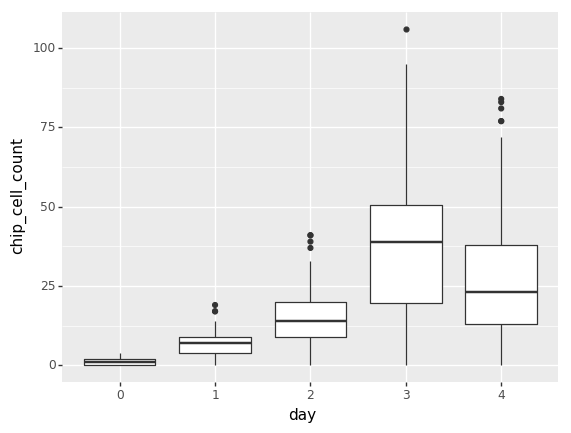

<ggplot: (-9223363310465695477)>

In [256]:
import plotnine as pn
(
    pn.ggplot(
        df_chip.assign(day=df_chip['image_meta_day'].astype(str)), 
        pn.aes(x='day', y='chip_cell_count')
    ) +
    pn.geom_boxplot()
)